In [2]:
import pandas as pd
import matplotlib
import sys
import pylab
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from IPython.display import display, HTML
import matplotlib.pyplot as plt

In [3]:
def process_perc_remote(name):
    df = pd.read_csv(name)
    df['perc_remote_txns'] = 1 - (1 - df['PERC_REMOTE'])**16
    df.to_csv(name, index=False)
def process_read_ratio(name):
    df = pd.read_csv(name)
    df['perc_readonly_txns'] = (df['READ_PERC'])**16
    df.to_csv(name, index=False)

def calculate_avg(df, i, j, k, weight, x, y):
    total = 0
    sum_val = 0
    for m in list(df['NODE_ID'].unique()):
        row = df.loc[(df['COMMIT_ALG'] == i) & (df[x] == j) & (df['i'] == k) & (df['NODE_ID'] == m)]
        if len(row[weight].values) == 0:
            continue
        total += row[weight].values[0]
        sum_val += row[weight].values[0] * row[y].values[0]
    if total == 0:
        return -1
    average_val = sum_val / total
    return average_val

def preprocess_data(name, x, weight='num_multi_part_txn', y='average_dist_latency'):
    df = pd.read_csv(name+'.csv') 
#     df = df[df[y].notna()]
    df = df.dropna(subset=[y])
    df = df[df['Throughput'] != 0]
#     display(df)
#     print(df.groupby(['COMMIT_ALG',x, 'NODE_ID', 'i'])['average_dist_latency'].min())
    df2 = df.groupby(['COMMIT_ALG',x, 'i'], as_index=False)['Throughput'].sum()
    df2 = df2.loc[df2.groupby(['COMMIT_ALG',x])['Throughput'].idxmax()]
#     display(df2)
    val_list= [y, '99%_latency', '99%_dist_latency', 'multi_part_execute_phase (in us)', 'multi_part_prepare_phase (in us)','multi_part_commit_phase (in us)', 'multi_part_abort (in us)']
    val_single = ['single_part_execute_phase (in us)', 'single_part_precommit_phase (in us)','single_part_commit_phase (in us)', 'single_part_abort (in us)']
    val_multi = ['multi_part_execute_phase (in us)', 'multi_part_prepare_phase (in us)','multi_part_commit_phase (in us)', 'multi_part_abort (in us)']
    val_all = ['99%_latency', 'average_latency']
    if y == 'average_dist_latency':
        result = pd.DataFrame([], columns = ['COMMIT_ALG', x, 'i'] + val_list)
    else:
        result = pd.DataFrame([], columns = ['COMMIT_ALG', x, 'i'] + val_all + val_single + val_multi)
    for i in list(df['COMMIT_ALG'].unique()):
        for j in list(df[x].unique()):
            for k in list(df['i'].unique()):
                row = {'COMMIT_ALG':i, x:j, 'i':k}
                row_nan = False
                if y == 'average_dist_latency':
                    for val in val_list:
                        average_val = calculate_avg(df, i, j, k, weight, x, val)
                        if average_val == -1:
                            row_nan = True
                        row[val] = average_val
                    if row_nan:
                        continue
                else:
                    for val in val_all:
                        average_val = calculate_avg(df, i, j, k, 'num_commits', x, val)
                        row[val] = average_val
                        if average_val == 0 and val == 'average_latency':
                            row_nan = True
                    for val in val_single:
                        average_val = calculate_avg(df, i, j, k, 'num_single_part_txn', x, val)
                        row[val] = average_val
                    if j != 0:
                        for val in val_multi:
                            average_val = calculate_avg(df, i, j, k, 'num_multi_part_txn', x, val)
                            row[val] = average_val
                    if row_nan:
                        continue
                result = result.append(row, ignore_index=True)
#     display(result)
    result = result.loc[result.groupby(['COMMIT_ALG',x])[y].idxmin()]
#     display(result)
    return df2, result

def breakdown(df, name, x, val):
#     name, x, val = 'ycsb_read_ratio_final', 'READ_PERC', 1
#     df = pd.read_csv(name+'.csv') 
    #     df = df[df[y].notna()]
    df = df.loc[df[x] == val] 
#     grouped = df.loc[df.groupby('COMMIT_ALG').avg_average_latency.idxmin()]
    latency = df[['COMMIT_ALG', 'multi_part_execute_phase (in us)', 'multi_part_prepare_phase (in us)','multi_part_commit_phase (in us)', 'multi_part_abort (in us)']]
    # single_latency = grouped[['COMMIT_ALG', 'single_part_execute_phase (in us)', 'single_part_precommit_phase (in us)','single_part_commit_phase (in us)', 'single_part_abort (in us)']]
    result = latency
    result = result.replace("ONE_PC", "1pc_distributed")
    result = result.replace("TWO_PC", "2pc_distributed")
    result = result.rename(columns={"multi_part_execute_phase (in us)": "execute", "multi_part_prepare_phase (in us)": "prepare", \
                                   'multi_part_commit_phase (in us)':'commit', 'multi_part_abort (in us)':'abort'})
    # single_latency = single_latency.replace("ONE_PC", "1pc_local")
    # single_latency = single_latency.replace("TWO_PC", "2pc_local")
    # single_latency = single_latency.rename(columns={"single_part_execute_phase (in us)": "execute", "single_part_precommit_phase (in us)": "prepare", \
    #                                    'single_part_commit_phase (in us)':'commit', 'single_part_abort (in us)':'abort'})
    display(result)
    # display(single_latency)
    # result = pd.concat([single_latency, result])
    # display(result)
    #     display(HTML(result.to_html(index=False)))
    #     result = result.drop(['NUM_RPC_SERVER_THREADS'], axis=1)
    #     colors = sns.color_palette("cubehelix", n_colors=5)
    colors = ["dimgray", "gold", "lawngreen", "lightseagreen"]
    cmap1 = LinearSegmentedColormap.from_list("my_colormap", colors)
    latency_plot= result.plot.bar(stacked='True', x='COMMIT_ALG', edgecolor='black', rot=0, colormap=cmap1)
    latency_plot.set_ylabel("Latency Breakdown(us)", fontsize=12)
    latency_plot.tick_params(axis='both', which='major', labelsize=12)
    # hide the axes frame and the x/y labels
    fig = latency_plot.get_figure()
    fig.set_size_inches(4.8, 3.8)
    fig.savefig(name+str(val)+".pdf", bbox_inches="tight")

In [4]:
def line_graph(df, name, x, y, op='max', label='', tail_latency=False, improv=True, improv_bar=True):
#     df = pd.read_csv(name+'.csv') 
#     df = df[df[y].notna()]
    grouped = df.groupby(['COMMIT_ALG', x])
    if op == 'max':
        newdf = grouped[y].max().reset_index()
    elif op == 'min':
        newdf = df.loc[df.groupby(['COMMIT_ALG', x])[y].idxmin()]
    else:
        newdf = grouped[y].mean().reset_index()
    if y == "avg_avg_dist_latency" or y == "avg_average_latency":
        newdf[y] = newdf[y]*1000
        newdf['99%_latency'] = newdf['99%_latency']*1000
        newdf['99%_dist_latency'] = newdf['99%_dist_latency']*1000
    if x == "LOG_DELAY":
        newdf[x] = newdf[x]/1000
    one_pc = newdf.loc[newdf['COMMIT_ALG'] == 'ONE_PC']  
    two_pc = newdf.loc[newdf['COMMIT_ALG'] == 'TWO_PC'] 
    if improv:
        s1 = one_pc.set_index(x)
        s2 = two_pc.set_index(x)
        latency_improvement = ((s2[y] - s1[y]) / s2[y]).reset_index(name=y)
        print(latency_improvement)

    print_list = newdf.pivot(index=x, columns='COMMIT_ALG', values=y)
    # newdf = newdf.drop([20])
    display(print_list)
    fig, ax = plt.subplots()
    ax.plot(x, y,marker='^', data=one_pc, linestyle='-', label='1PC '+ label, color='dimgrey')
    ax.plot(x, y, marker='^', data=two_pc, linestyle='--', label='2PC ' + label, color='darkorange')
    ax.legend(loc='upper center', bbox_to_anchor=(0.24, 1.25))
    ax.set_ylim([0, newdf[y].max()*1.1])
    
    if y == "Throughput":
        ax.set_ylabel("Throughput (Txn/s)", fontsize=12)
    elif y == "average_latency":
        ax.set_ylabel("Txn Latency (ms)", fontsize=12)
    elif y == "average_dist_latency":
        ax.set_ylabel("Distributed Txn Latency (ms)", fontsize=12)
    else:
        plt.ylabel(y)
    if x == "READ_PERC":
        ax.set_xlabel("Read Ratio", fontsize=12)
    elif x == "PERC_REMOTE":
        ax.set_xlabel("Percentage of remote txns", fontsize=12)
    elif x == "perc_remote_txns":
        ax.set_xlabel("Percentage of remote txns", fontsize=12)
    elif x == "perc_readonly_txns":
        ax.set_xlabel("Percentage of read-only txns", fontsize=12)
    elif x == "LOG_DELAY":
        ax.set_xlabel("logging delay time(ms)", fontsize=12)
    else:
        ax.set_xlabel(x)
#     if y == "avg_avg_dist_latency" or y == "avg_average_latency" or y == "avg_multi_part_abort (in us)":
    if improv:
        ax = plt.gca()
        ax2 = ax.twinx()
        if improv_bar:
            ax2.bar(latency_improvement[x], height=latency_improvement[y], width=0.05, alpha=0.4, hatch='/', label='Average abort phase reduction' if y == "avg_multi_part_abort (in us)" else 'Average Latency Reduction')
        else:
            ax2.plot(x, y, marker='+', data=latency_improvement, linestyle='-.', label='Average abort phase reduction' if y == "avg_multi_part_abort (in us)" else 'Average Latency Reduction', color='g')
        ax2.set_ylabel('Latency Reduction', fontsize=12)  # we already handled the x-label with ax1
        ax2.legend(loc='upper center',bbox_to_anchor=(0.8, 1.2))
        ax2.set_ylim([0, latency_improvement[y].max()*1.1])
    if tail_latency:
        if y == "average_latency":
            ax.plot(x, '99%_latency', marker='o', data=one_pc, linestyle='-', label='1PC 99% latency', color='dimgrey')
            ax.plot(x, '99%_latency', marker='o', data=two_pc, linestyle='--', label='2PC 99% latency', color='darkorange')
            ax.legend(loc='upper center', bbox_to_anchor=(0.24, 1.35))
            ax.set_ylim([0, newdf['99%_latency'].max()*1.1])
        if y == "average_dist_latency":
            ax.plot(x, '99%_dist_latency', marker='o', data=one_pc, linestyle='-', label='1PC 99% latency', color='dimgrey')
            ax.plot(x, '99%_dist_latency', marker='o', data=two_pc, linestyle='--', label='2PC 99% latency', color='darkorange')
            ax.legend(loc='upper center', bbox_to_anchor=(0.24, 1.35))
            ax.set_ylim([0, newdf['99%_dist_latency'].max()*1.1])

#     plt.tight_layout()
    plt.ylim(bottom=0)
    plt.grid(axis='y')
    plt.tick_params(axis='both', which='major', labelsize=12)

    fig.set_size_inches(4.8, 3.8)
    plt.savefig(name+y+".pdf",bbox_inches='tight')

,COMMIT_ALG,perc_remote_txns,i,99%_latency,average_latency,single_part_execute_phase (in us),single_part_precommit_phase (in us),single_part_commit_phase (in us),single_part_abort (in us),multi_part_execute_phase (in us),multi_part_prepare_phase (in us),multi_part_commit_phase (in us),multi_part_abort (in us)
0,ONE_PC,0.000000,0,0.004265,0.003045,534.279312,0.0,2510.858531,0.308154,NaN,NaN,NaN,NaN
1,ONE_PC,0.000000,1,0.004318,0.003054,504.805983,0.0,2548.968125,0.271002,NaN,NaN,NaN,NaN
2,ONE_PC,0.000000,2,0.004474,0.003126,543.785915,0.0,2581.601080,0.259694,NaN,NaN,NaN,NaN
3,ONE_PC,0.276202,0,0.005460,0.003350,485.102581,0.0,2601.666703,0.467774,1157.476392,2724.997680,151.622824,0.330751
4,ONE_PC,0.276202,1,0.005427,0.003298,474.989896,0.0,2554.555348,0.617584,1143.393999,2703.919772,149.276987,0.501407
5,ONE_PC,0.276202,2,0.005437,0.003328,487.348624,0.0,2581.245460,0.505703,1142.545587,2708.820117,151.032939,0.173909
6,ONE_PC,0.559873,0,0.005686,0.003469,430.524867,0.0,2430.692438,0.209375,1068.425076,2746.050337,139.112410,0.423561
7,ONE_PC,0.559873,1,0.005842,0.003599,522.297793,0.0,2527.723268,0.701922,1175.120565,2719.151819,142.449703,0.169728
8,ONE_PC,0.559873,2,0.005816,0.003560,494.402958,0.0,2506.348730,0.688871,1141.517481,2724.564868,140.297068,0.288448
9,ONE_PC,0.814698,0,0.006852,0.003895,511.927196,0.0,2487.896651,0.000000,1149.876464,2811.633361,140.314781,0.172617


,COMMIT_ALG,perc_remote_txns,i,99%_latency,average_latency,single_part_execute_phase (in us),single_part_precommit_phase (in us),single_part_commit_phase (in us),single_part_abort (in us),multi_part_execute_phase (in us),multi_part_prepare_phase (in us),multi_part_commit_phase (in us),multi_part_abort (in us)
0,ONE_PC,0.000000,0,0.004265,0.003045,534.279312,0.0,2510.858531,0.308154,NaN,NaN,NaN,NaN
4,ONE_PC,0.276202,1,0.005427,0.003298,474.989896,0.0,2554.555348,0.617584,1143.393999,2703.919772,149.276987,0.501407
6,ONE_PC,0.559873,0,0.005686,0.003469,430.524867,0.0,2430.692438,0.209375,1068.425076,2746.050337,139.112410,0.423561
9,ONE_PC,0.814698,0,0.006852,0.003895,511.927196,0.0,2487.896651,0.000000,1149.876464,2811.633361,140.314781,0.172617
15,ONE_PC,0.971853,3,0.008461,0.004454,557.205128,0.0,2426.374933,0.000000,1279.363964,3067.764772,149.902470,0.183649
18,TWO_PC,0.000000,0,0.004301,0.003012,479.006175,0.0,2533.360140,0.095303,NaN,NaN,NaN,NaN
23,TWO_PC,0.276202,2,0.008019,0.003892,501.509322,0.0,2579.274951,0.094687,1175.760917,2700.133038,2131.454609,0.856352
26,TWO_PC,0.559873,2,0.008328,0.004557,420.235625,0.0,2410.121121,0.363858,1072.710567,2722.621536,2139.201104,0.999070
28,TWO_PC,0.814698,1,0.009199,0.005522,500.228566,0.0,2444.520642,0.000000,1153.673347,2773.531814,2193.080195,0.266386
34,TWO_PC,0.971853,4,0.010183,0.006345,498.647857,0.0,2374.153836,0.000000,1197.695160,2973.207995,2280.094819,0.295702


COMMIT_ALG,ONE_PC,TWO_PC
perc_remote_txns,,
0.000000,5223.710,5281.070
0.276202,3985.170,3680.653
0.559873,3248.373,2899.818
0.814698,2611.678,2243.180
0.971853,2157.598,1823.036


   perc_remote_txns  average_latency
0          0.000000        -0.010950
1          0.276202         0.152576
2          0.559873         0.238648
3          0.814698         0.294718
4          0.971853         0.298141


COMMIT_ALG,ONE_PC,TWO_PC
perc_remote_txns,,
0.000000,0.003045,0.003012
0.276202,0.003298,0.003892
0.559873,0.003469,0.004557
0.814698,0.003895,0.005522
0.971853,0.004454,0.006345


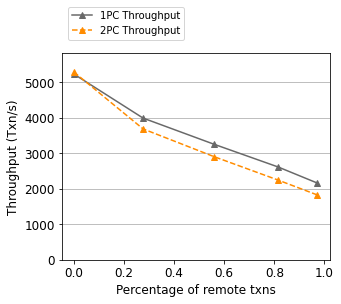

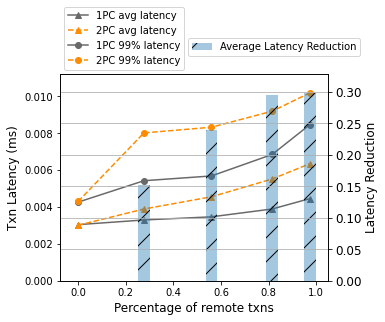

In [88]:
process_perc_remote('ycsb_perc_remote_concat.csv')
throughput, latency = preprocess_data('ycsb_perc_remote_concat', "perc_remote_txns", y='average_latency')
display(latency)
line_graph(throughput, 'ycsb_perc_remote_concat', 'perc_remote_txns', 'Throughput', 'max', 'Throughput', tail_latency=False, improv=False, improv_bar=False)
line_graph(latency, 'ycsb_perc_remote_concat', 'perc_remote_txns', 'average_latency', 'min', 'avg latency', tail_latency=True, improv_bar=True)

COMMIT_ALG,ONE_PC,TWO_PC
perc_readonly_txns,,
0.000000,11032.06,9337.16
0.185302,19341.50,18579.38
0.440127,26341.42,25929.05
0.723798,39917.57,36690.03
1.000000,52824.30,52128.10


   perc_readonly_txns  average_dist_latency
0            0.000000              0.330399
1            0.185302              0.366689
2            0.440127              0.288246
3            0.723798              0.257012
4            1.000000              0.018740


COMMIT_ALG,ONE_PC,TWO_PC
perc_readonly_txns,,
0.000000,0.005686,0.008492
0.185302,0.003334,0.005264
0.440127,0.002799,0.003932
0.723798,0.002294,0.003088
1.000000,0.002524,0.002572


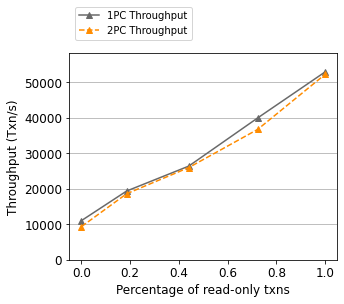

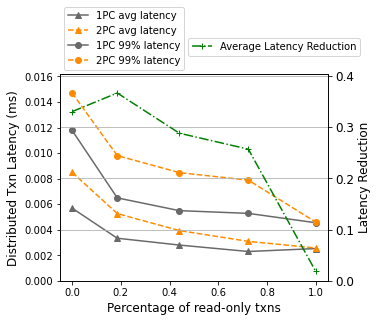

In [5]:
process_read_ratio('ycsb_read_ratio_concat_1215.csv')
throughput, latency = preprocess_data('ycsb_read_ratio_concat_1215', "perc_readonly_txns")
# display(latency)
line_graph(throughput, 'ycsb_read_ratio_concat_1215', 'perc_readonly_txns', 'Throughput', 'max', 'Throughput', tail_latency=False, improv=False, improv_bar=False)
line_graph(latency, 'ycsb_read_ratio_concat_1215', 'perc_readonly_txns', 'average_dist_latency', 'min', 'avg latency', tail_latency=True, improv_bar=False)

COMMIT_ALG,ONE_PC,TWO_PC
ZIPF_THETA,,
0.00,12530.6500,11050.3200
0.60,12146.0800,11245.0500
0.80,7123.4500,6607.9000
0.90,2527.9910,2333.7670
0.99,1102.6800,879.5900
1.10,473.0540,317.9269
1.20,251.4817,143.9732
1.30,189.1238,97.6552


   ZIPF_THETA  average_dist_latency
0        0.00              0.361766
1        0.60              0.309287
2        0.80              0.221516
3        0.90              0.168008
4        0.99              0.254930
5        1.10              0.348546
6        1.20              0.442358
7        1.30              0.477484


COMMIT_ALG,ONE_PC,TWO_PC
ZIPF_THETA,,
0.00,0.005079,0.007957
0.60,0.005364,0.007766
0.80,0.010796,0.013868
0.90,0.035129,0.042222
0.99,0.090510,0.121479
1.10,0.231701,0.355667
1.20,0.467158,0.837739
1.30,0.653756,1.251169


,COMMIT_ALG,execute,prepare,commit,abort
2,1pc_distributed,1346.964986,3617.045084,112.148211,2.472451
23,2pc_distributed,1497.192338,3511.003018,2946.152633,2.973122


,COMMIT_ALG,execute,prepare,commit,abort
7,1pc_distributed,930.698545,3074.980179,115.174937,6675.355271
28,2pc_distributed,1074.485936,3084.357263,2502.783311,7206.581247


,COMMIT_ALG,execute,prepare,commit,abort
21,1pc_distributed,691.052724,2657.144782,108.987600,6.502985e+05
43,2pc_distributed,762.227969,2688.165845,2106.220298,1.245612e+06


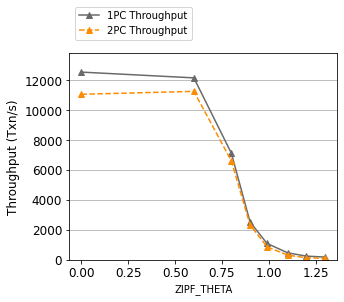

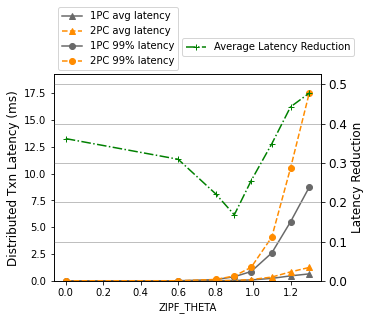

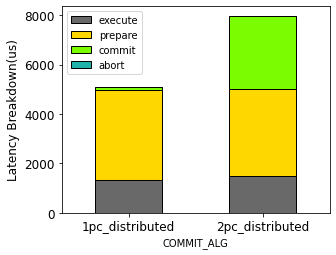

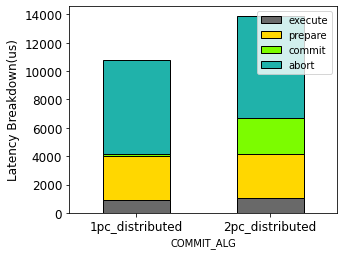

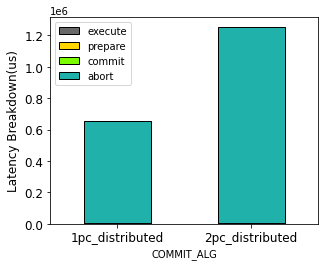

In [23]:
throughput, latency = preprocess_data('ycsb_zipf_concat', "ZIPF_THETA")
line_graph(throughput, 'ycsb_zipf', 'ZIPF_THETA', 'Throughput', 'max', 'Throughput', tail_latency=False, improv=False, improv_bar=False)
line_graph(latency, 'ycsb_zipf', 'ZIPF_THETA', 'average_dist_latency', 'min', 'avg latency', tail_latency=True, improv_bar=False)
breakdown(latency, 'ycsb_zipf_concat', 'ZIPF_THETA', 0)
breakdown(latency, 'ycsb_zipf_concat', 'ZIPF_THETA', 0.8)
breakdown(latency, 'ycsb_zipf_concat', 'ZIPF_THETA', 1.3)

COMMIT_ALG,ONE_PC,TWO_PC
LOG_DELAY,,
0.0,13170.640,11155.680
1.0,11143.260,9669.750
2.0,8995.240,7817.190
4.0,6837.670,5798.310
8.0,4551.830,3802.306
16.0,2658.854,2207.915
32.0,1454.024,1204.357


   LOG_DELAY  average_dist_latency
0        0.0              0.403059
1        1.0              0.386199
2        2.0              0.405691
3        4.0              0.446942
4        8.0              0.462395
5       16.0              0.478003
6       32.0              0.487876


COMMIT_ALG,ONE_PC,TWO_PC
LOG_DELAY,,
0.0,0.004690,0.007856
1.0,0.005544,0.009032
2.0,0.006491,0.010922
4.0,0.008158,0.014750
8.0,0.012033,0.022382
16.0,0.019994,0.038302
32.0,0.035994,0.070284


,COMMIT_ALG,execute,prepare,commit,abort
6,1pc_distributed,1104.638761,3469.238553,113.129651,2.847857
76,2pc_distributed,1507.923925,3464.483322,2880.705293,3.380926


,COMMIT_ALG,execute,prepare,commit,abort
10,1pc_distributed,1091.190946,4326.153320,122.378428,4.034521
85,2pc_distributed,1032.991848,4217.468028,3777.273123,4.115718


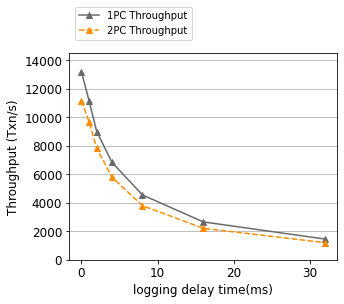

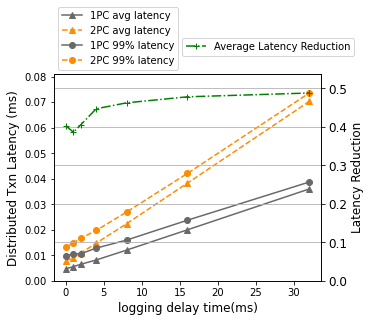

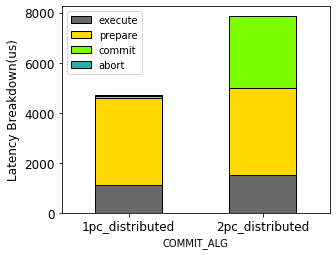

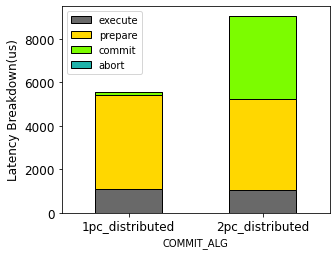

In [6]:
throughput, latency = preprocess_data('ycsb_log_delay_concat_1215', "LOG_DELAY")
line_graph(throughput, 'ycsb_log_delay_concat_1215', 'LOG_DELAY', 'Throughput', 'max', 'Throughput', tail_latency=False, improv=False, improv_bar=False)
line_graph(latency, 'ycsb_log_delay_concat_1215', 'LOG_DELAY', 'average_dist_latency', 'min', 'avg latency', tail_latency=True, improv_bar=False)
breakdown(latency, 'ycsb_log_delay_concat_1215', 'LOG_DELAY', 0)
breakdown(latency, 'ycsb_log_delay_concat_1215', 'LOG_DELAY', 1000)

COMMIT_ALG,ONE_PC,TWO_PC
NUM_WH,,
1,2901.364,2903.036
2,5151.390,5147.100
4,8187.330,8138.010
8,11797.870,11704.000
16,15577.410,15442.770
24,17619.470,17344.450
32,18689.210,18481.510


   NUM_WH  average_dist_latency
0       1              0.028569
1       2              0.059070
2       4              0.105361
3       8              0.175250
4      16              0.241740
5      24              0.268099
6      32              0.279424


COMMIT_ALG,ONE_PC,TWO_PC
NUM_WH,,
1,0.048317,0.049738
2,0.026598,0.028268
4,0.016181,0.018086
8,0.010847,0.013152
16,0.007729,0.010193
24,0.006670,0.009114
32,0.006208,0.008615


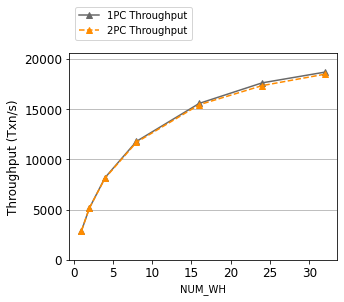

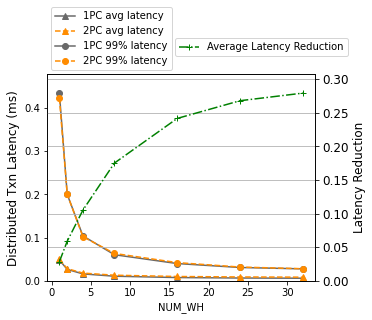

In [9]:
throughput, latency = preprocess_data('tpcc_wh_concat', "NUM_WH")
line_graph(throughput, 'tpcc_wh_concat', 'NUM_WH', 'Throughput', 'max', 'Throughput', tail_latency=False, improv=False, improv_bar=False)
line_graph(latency, 'tpcc_wh_concat', 'NUM_WH', 'average_dist_latency', 'min', 'avg latency', tail_latency=True, improv_bar=False)

COMMIT_ALG,ONE_PC,TWO_PC
NUM_NODES,,
2,6316.82,5788.74
4,12737.00,11669.72
6,19235.87,17937.41
8,24779.88,22219.34


   NUM_NODES  average_dist_latency
0          2              0.318650
1          4              0.335816
2          6              0.314752
3          8              0.345746


COMMIT_ALG,ONE_PC,TWO_PC
NUM_NODES,,
2,0.005042,0.007400
4,0.004929,0.007421
6,0.004930,0.007194
8,0.005253,0.008029


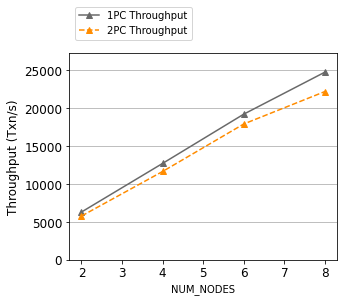

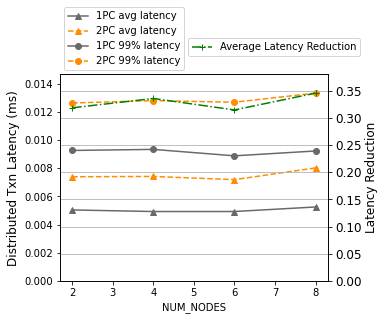

In [140]:
throughput, latency = preprocess_data('ycsb_scalability_concat', "NUM_NODES")
line_graph(throughput, 'ycsb_scalability_concat', 'NUM_NODES', 'Throughput', 'max', 'Throughput', tail_latency=False, improv=False, improv_bar=False)
line_graph(latency, 'ycsb_scalability_concat', 'NUM_NODES', 'average_dist_latency', 'min', 'avg latency', tail_latency=True, improv=True, improv_bar=False)

COMMIT_ALG,ONE_PC,TWO_PC
NUM_NODES,,
2,9546.80,9337.35
4,18825.76,18320.32
6,28056.65,27239.37
8,37426.53,36596.06


   NUM_NODES  average_dist_latency
0          2              0.314694
1          4              0.298282
2          6              0.310542
3          8              0.289811


COMMIT_ALG,ONE_PC,TWO_PC
NUM_NODES,,
2,0.006051,0.008830
4,0.006130,0.008736
6,0.006177,0.008959
8,0.006178,0.008698


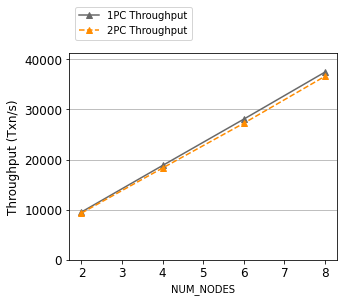

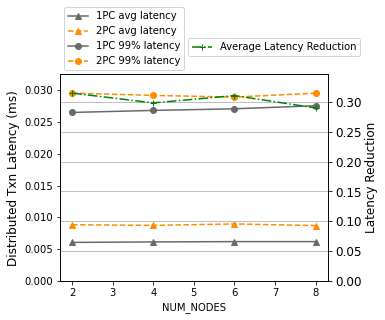

In [133]:
throughput, latency = preprocess_data('tpcc_scalability_concat', "NUM_NODES")
line_graph(throughput, 'tpcc_scalability_concat', 'NUM_NODES', 'Throughput', 'max', 'Throughput', tail_latency=False, improv=False, improv_bar=False)
line_graph(latency, 'tpcc_scalability_concat', 'NUM_NODES', 'average_dist_latency', 'min', 'avg latency', tail_latency=True, improv=True, improv_bar=False)